In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sns.set(style='white')

# Select the disease you want to find compounds for
DISEASE = 'DOID:2377'
DISEASE_NAME = "MS"
%matplotlib inline


In [2]:
# Load dataframes 
compound_info_df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/baranzini-lab/PSPG_245B/master/spoke_compound_info.tsv', sep='\t', header=0).reset_index()
query_df = pd.read_csv('https://raw.githubusercontent.com/baranzini-lab/PSPG_245B/master/query_table.tsv', sep='\t', header=0).reset_index()
meta_path_list = query_df['Abbrev.'].values
path_count_and_dwpc_df =pd.read_csv('https://raw.githubusercontent.com/baranzini-lab/PSPG_245B/master/%s_path_table.tsv'%DISEASE_NAME, sep='\t', header=0)
compound_list = path_count_and_dwpc_df.Compound.unique()
compound_category_and_trial_count_df = pd.DataFrame.from_csv('https://raw.githubusercontent.com/baranzini-lab/PSPG_245B/master/%s_known_relationships.tsv'%DISEASE_NAME, sep='\t', header=0).reset_index().fillna('NULL')



In [3]:
compound_info_df.head()

,node,Name
0,DB01148,Flavoxate
1,DB01359,Penbutolol
2,DB00246,Ziprasidone
3,DB04878,Voglibose
4,DB06589,Pazopanib


In [4]:
path_count_and_dwpc_df.head()

,Compound,Meta_Path,Path_Count,DWPC
0,DB01148,CbGaD,0,0
1,DB01148,CdGuD,0,0
2,DB01148,CrCtD,0,0
3,DB01148,CtDrD,0,0
4,DB01148,CuGdD,0,0


In [5]:
compound_category_and_trial_count_df.head()

,node,Name,Cat,Trials
0,DB06151,Acetylcysteine,NULL,2
1,DB00341,Cetirizine,NULL,1
2,DB01114,Chlorphenamine,NULL,1
3,DB00993,Azathioprine,DM,1
4,DB00594,Amiloride,NULL,2


In [6]:
query_df.head()

,index,Abbrev.,Metapath,meta_query
0,0,CbGaD,(c:Compound)-[:BINDS_CbG]-(:Gene)-[:ASSOCIATES...,(n0:Compound)-[:BINDS_CbG]-(n%s)-[:ASSOCIATES_...
1,1,CdGuD,(c:Compound)-[:DOWNREGULATES_CdG]-(:Gene)-[:UP...,(n0:Compound)-[:DOWNREGULATES_CdG]-(n%s)-[:UPR...
2,2,CrCtD,(c:Compound)-[:RESEMBLES_CrC]-(:Compound)-[:TR...,(n0:Compound)-[:RESEMBLES_CrC]-(n%s)-[:TREATS_...
3,3,CtDrD,(c:Compound)-[:TREATS_CtD]-(:Disease)-[:RESEMB...,(n0:Compound)-[:TREATS_CtD]-(n%s)-[:RESEMBLES_...
4,4,CuGdD,(c:Compound)-[:UPREGULATES_CuG]-(:Gene)-[:DOWN...,(n0:Compound)-[:UPREGULATES_CuG]-(n%s)-[:DOWNR...


In [7]:
# write a function to turn dataframe into matrix
pc_and_dwpc_matrix = df_to_matrix(compound_list, meta_path_list, path_count_and_dwpc_df)

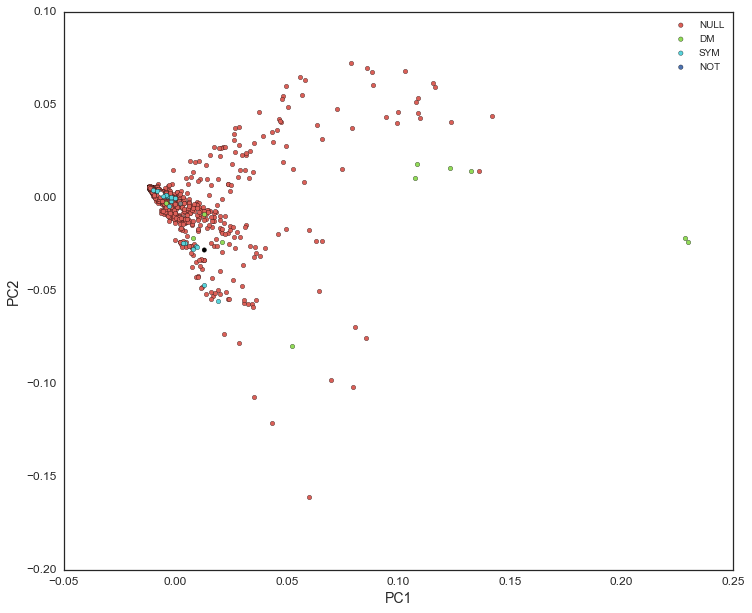

In [8]:
# write a function to plot the PCA using path count, DWPC, or both
matrix_index=1
pca = PCA(n_components=2)
embedded = pca.fit_transform(pc_and_dwpc_matrix[matrix_index])
plot_2d(compound_category_and_trial_count_df, pc_and_dwpc_matrix, compound_list, embedded, 'Cat', matrix_index)


In [9]:
# Find the explained variance
component_df = get_variance_explained_and_top_meta_paths(pca, meta_path_list)
# Find the most important meta-paths (note: here we are using the abs of the components)
print '\nTop Meta Paths'
component_df.sort_values(['PC1', 'PC2'], ascending=False).head()

PC1 34.0 and PC2 19.0

Top Meta Paths


,Meta_Path,PC1,PC2
13,CrCrCtD,0.534871,0.463623
22,CuGuCtD,0.37382,0.120677
9,CdGdCtD,0.358734,0.141259
11,CiPCiCtD,0.319097,0.152431
8,CcSEcCtD,0.314782,0.170656


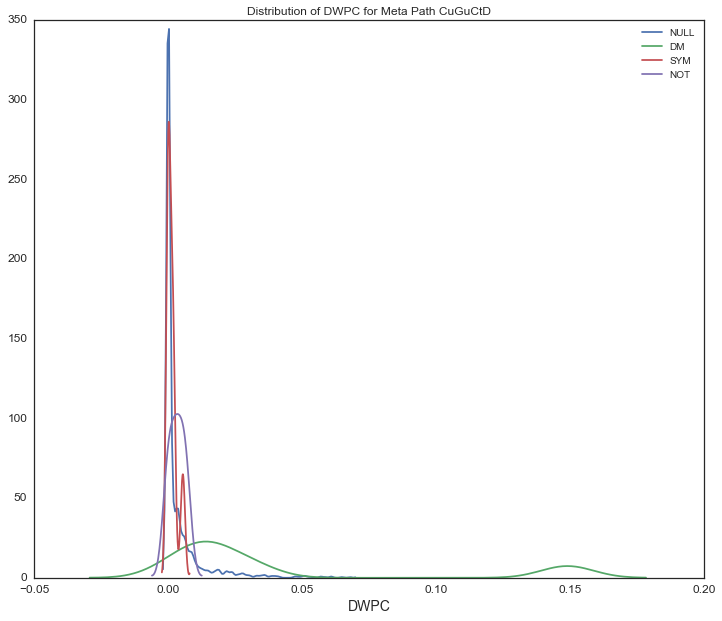

Top Compounds


,Compound,Meta_Path,Path_Count,DWPC,node,Name,Cat,Trials
32730,DB01234,CuGuCtD,270,0.149015,DB01234,Dexamethasone,DM,1
8290,DB00443,CuGuCtD,270,0.149015,DB00443,Betamethasone,DM,0
8368,DB01222,CuGuCtD,171,0.067881,DB01222,Budesonide,NULL,0
37410,DB01177,CuGuCtD,209,0.064797,DB01177,Idarubicin,NULL,0
35902,DB00997,CuGuCtD,191,0.060887,DB00997,Doxorubicin,NULL,0


In [10]:
# Look at the distributions of different meta paths.
# Do the disease-modifying comp separate from the rest?
meta_path='CuGuCtD'
spec_meta_path_info = look_at_distribution_of_DWPC(path_count_and_dwpc_df, compound_category_and_trial_count_df, meta_path)
print 'Top Compounds'
spec_meta_path_info.sort_values(['DWPC'], ascending=False).head()

In [11]:
# After you find meta-paths with good separation, look at the top hits in Neo4j
# Write a function to create a Cyper query that will show you the meta paths between the disease and compound
get_cyper_query(query_df, compound = 'DB01234', meta_path='CuGuCtD')

MATCH path=(c:Compound)-[:UPREGULATES_CuG]-(:Gene)-[:UPREGULATES_CuG]-(:Compound)-[:TREATS_CtD]-(d:Disease) WHERE c.identifier="DB01234" AND d.identifier="DOID:2377" RETURN path LIMIT 5


In [12]:
from IPython.display import Image
from IPython.core.display import HTML 
# This is the output of the above query in Neo4j
Image(url= "ms_example_output.png")

In [13]:
# Once you have a good Disease-Compound pair..
# check how it did & look at top 10 paths 
compound = 'DB01234'
print 'https://neo4j.het.io/browser/?cmd=play&arg=https://neo4j.het.io/guides/rep/%s/%s.html' % (compound, '_'.join(DISEASE.split(':')))

https://neo4j.het.io/browser/?cmd=play&arg=https://neo4j.het.io/guides/rep/DB01234/DOID_2377.html


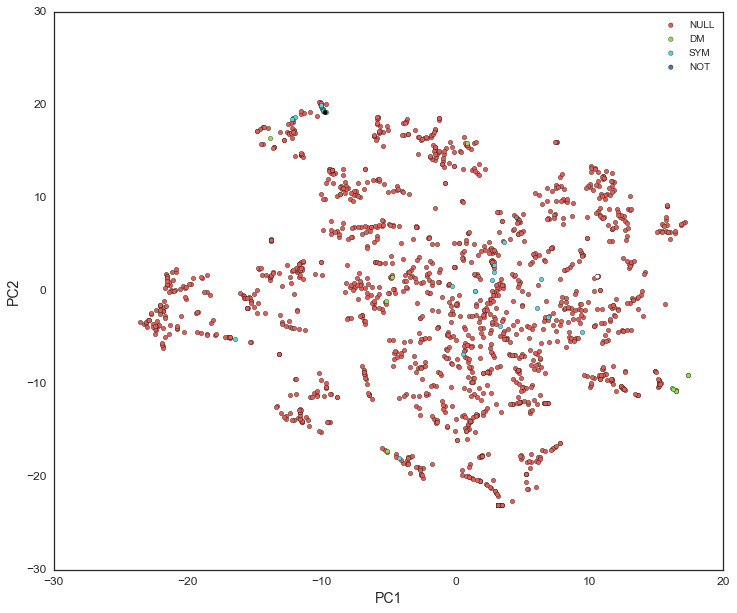

In [14]:
# Plot the results using TSNE
tsne =TSNE(n_components=2)
embedded = tsne.fit_transform(pc_and_dwpc_matrix[matrix_index])
plot_2d(compound_category_and_trial_count_df, pc_and_dwpc_matrix, compound_list, embedded, 'Cat', matrix_index)